# Autoencoder generating MNIST Data.
This notebook demonstrates the generation of autoencoder data on MNIST datasets.
<br>
We are going to use two data sets here. To know more about the datasets vist the links given :- 
  - MNIST Handwritten Digits - [link](http://yann.lecun.com/exdb/mnist/)
  - MNIST Fashion            - [link](https://github.com/zalandoresearch/fashion-mnist)

We are only using Neural Network based architecture here. In future work I tend to implement a CovNet based architecture. In this notebook we are also going to discuss the activations in the bottleneck layer.<br><br>
##### This is the basic structure of the architecture used here.
![autoencoder architecture](images/autoencoder.jpg)


## Required Imports

In [1]:
import tensorflow as tf
import keras
from keras.layers import Dense, Input, Dropout
from keras.models import Model, load_model
from keras.datasets import mnist, fashion_mnist
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from time import time
import os

# Since I am using a dark backgroud. Comment it out if you are using a light theme
plt.style.use(['dark_background'])

# tensorboard --logdir=logs/ --host localhost --port 8088
print(f'Tensorflow Version - {tf.__version__}')
print(f'Keras Version - {keras.__version__}')

Using TensorFlow backend.


Tensorflow Version - 1.12.0
Keras Version - 2.2.4


## Some project oriented values

In [2]:
DATASET = 'digit'
MODEL_NAME = f'FCCN_{DATASET}_autoencoder'
MODEL_CHECKPOINT_PATH = f'saved_models/checkpoint/{MODEL_NAME}_epoch-'
MODEL_PATH = f'saved_models/{MODEL_NAME}.h5'

## Architecture of the model used in this project

In [3]:
def get_models(saved = True):
    """This method returns the autoencoder model and the encoder model.
    Returns a saved model if MODEL_NAME is found.
    Fully Connected Neural Network Autoencoder Architecture (FCCN Autoencoder)
    
    Keyword Arguments:
    saved - Get the saved model from the MODEL_PATH if exists.(default True)
    
    Returns:
    autoencoder_model - Uncompiled Keras model for autoencoder network
    encoder_model     - Uncompiled Keras model for encoder network for 
                        future activation map visualization.
    """
    tf.reset_default_graph()
    
    if os.path.isfile(MODEL_PATH) and saved:
        print("Loading saved model {}".format(MODEL_NAME))
        autoencoder_model = load_model(MODEL_PATH)
        
        input_layer = Input(shape=(784,),name='input_layer')
        output_layer = input_layer
        layers_list = autoencoder_model.layers

        index  = 1
        while True:
            #print(f'Layer Index {index}')
            layer = layers_list[index]
            output_layer = layer (output_layer)
            index +=1
            if layer.name == 'bottleneck_layer':
                break
        encoder_model = Model(input_layer,output_layer)
        
        return autoencoder_model,encoder_model
    
    
    dropout_rate = 0.13
    input_layer = Input(shape=(784,),name='input_layer')
    layer = Dense(512,name='encode_1',activation='relu')(input_layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(256,name='encode_2',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(128,name='encode_3',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(64,name='encode_4',activation='relu')(layer)
    
    bottleneck_layer = Dense(36,name='bottleneck_layer',activation='relu')(layer)
    
    layer = Dense(64,name='decode_1',activation='relu')(bottleneck_layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(128,name='decode_2',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(256,name='decode_3',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(512,name='decode_4',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    output_layer = Dense(784,name='output_layer',activation='sigmoid')(layer)
    
    
    autoencoder_model = Model(input_layer,output_layer)
    encoder_model = Model(input_layer,bottleneck_layer)
    return autoencoder_model,encoder_model

## Utility Functions

In [4]:
def process_data(data_type = 'digit'):
    """This method returns the train and test data.
    
    Keyword Arguments:
    data_type - Name of the dataset used.(default 'digit')
                'digit' - MNIST Digits Dataset
                'fashion' - MNIST Fashion Dataset
    
    Returns:
    train,test - The training and testing data for respective datasets.
    """
    train,test = None, None
    if data_type == 'digit':
        print('Loading MNIST Digit Dataset')
        (train,_),(test,_) = mnist.load_data()
    elif data_type == 'fashion' :
        print('Loading MNIST Fashion Dataset')
        (train,_),(test,_) = fashion_mnist.load_data()
    train = train/255
    test = test/255
    train = train.reshape((len(train), np.prod(train.shape[1:])))
    test = test.reshape((len(test), np.prod(test.shape[1:])))
    print(f'Training Data Shape : {train.shape}')
    print(f'Testing Data Shape  : {test.shape}')
    return train,test

X_train, X_test = process_data(data_type=DATASET)

Loading MNIST Digit Dataset
Training Data Shape : (60000, 784)
Testing Data Shape  : (10000, 784)


In [5]:
def plot_result(original,activation,created):
    """This method plots the original image,activation map of the bottleneck layer
    and reconstructed image.
    
    Keyword Arguments:
    original   - Numpy array of the original data (shape = (784,))
    activation - Numpy array of the activation map data (shape = (36,))
    created    -  Numpy array of the reconstructed data (shape = (784,))
    
    """
    shape = int(np.sqrt(original.shape[0]))
    map_shape = int(np.sqrt(activation.shape[0]))
    
    original = np.reshape(original,(shape,shape))
    activation = np.reshape(activation,(map_shape,map_shape))
    created = np.reshape(created,(shape,shape))
    
    plt.figure(figsize=(14,10))
    
    gs = gridspec.GridSpec(4, 8)
    gs.update(wspace=0.5)
    ax1 = plt.subplot(gs[:2, :4], )
    ax2 = plt.subplot(gs[:2, 4:])
    ax3 = plt.subplot(gs[2:, 2:6])
    
    ax1.set_title("Original Image\n",fontdict = {'fontsize':16})
    ax1.imshow(original,cmap = 'gray')
    ax1.set_axis_off()
    
    ax2.set_title("Re-Constructed Image\n",fontdict = {'fontsize':16})
    ax2.imshow(created,cmap = 'gray')
    ax2.set_axis_off()
    
    ax3.set_title("\nActivation Map of\n Bottleneck Layer",fontdict = {'fontsize':16})
    ax3.imshow(activation,cmap = 'gray')
    ax3.set_axis_off()

    plt.show()

In [6]:
def random_result():
    """This method picks up a random datapoint from testing data and plots the result image.
    Result image consists of Orginal Image, Re-Constructed Image and 
    Activation Map of Bottleneck Layer"""
    rand_idx = np.random.randint(0,len(X_test))
    plot_result(X_test[rand_idx],activation_map[rand_idx],autoencoder_prediction[rand_idx])

## Fetching the model

In [7]:
autoencoder,encoder = get_models()
print('Structure of Autoencoder Model\n')
autoencoder.summary()

Loading saved model FCCN_digit_autoencoder
Structure of Autoencoder Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 784)               0         
_________________________________________________________________
encode_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
encode_2 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
encode_3 (Dense)             (None, 128)               32896     
_________________________________________________________________
d

In [8]:
print('Structure of Encoder Model\n')
encoder.summary()

Structure of Encoder Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 784)               0         
_________________________________________________________________
encode_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
encode_2 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
encode_3 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)        

## Training Hyperparametrs

In [9]:
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 30

In [10]:
# Optimizer (Adam Optimizer)
adam = Adam(lr=LR)

# Making of missing directories.
if os.path.isdir('saved_models/') == False:
    os.makedirs('saved_models/')
if os.path.isdir('saved_models/checkpoint/') == False:
    os.makedirs('saved_models/checkpoint/')

# Declaring all the callbacks required.
tensoboard = TensorBoard(log_dir='logs\{}'.format(time()),batch_size=BATCH_SIZE,update_freq='epoch')
save_model = ModelCheckpoint(filepath=MODEL_CHECKPOINT_PATH+'{epoch}.h5',monitor='loss')
early_stop = EarlyStopping(monitor='loss',patience=3,verbose=1,restore_best_weights=True)

callbacks = [tensoboard,save_model,early_stop]

# Model Compilation
autoencoder.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

## Start Training

In [ ]:
hist = autoencoder.fit(X_train,X_train,batch_size=BATCH_SIZE,
                       epochs=EPOCHS,verbose=2,callbacks=callbacks)
autoencoder.save(MODEL_PATH)

## Results

In [11]:
autoencoder_prediction = autoencoder.predict(X_test)
activation_map = encoder.predict(X_test)

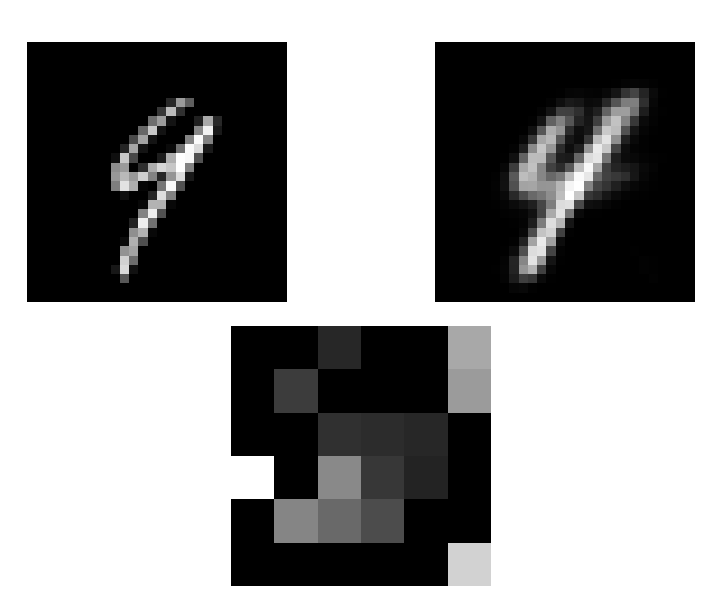

In [15]:
# For MNIST Handwritten Digits
random_result()

## Final Verdict
These graphs are form Tensorboard.
<br>

 ### MNIST Handwritten Digits
   - Final Loss - 0.1338
     ![](images\loss-digit.png)
<br>
   - Final Accuracy - 0.8069
     ![](images\acc-digit.png)